# Simple projectile motion in PyMC
Uncertainty in initial angle -> uncertainty in position

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

Model: projectile motion with an initial angle between 0 and $\pi/2$ and velocity $v_0$.

The impact distance is given by $x = v_0/g*\sin(2\theta)$

Note that we need to add a random variable $x_obs$ for observed impact point if we would like to infer
unknown $v_0$ and $\theta$.  See [Observed Deterministic](https://discourse.pymc.io/t/observed-deterministic/483) thread on the
PyMC discourse for reasons why we can't just observe $x$.

In [38]:
with pm.Model() as model:
    theta_scaled = pm.Beta('theta_scaled', 1, 1)
    theta = pm.Deterministic('theta', theta_scaled * np.pi/2)
    v0 = pm.Normal('v0', 10, 1)
    g = pm.Data('g', 9.8)
    x = pm.Deterministic('x', v0**2 / g * np.sin(2*theta))
    x_obs = pm.Normal('x_obs', x, 0.2)

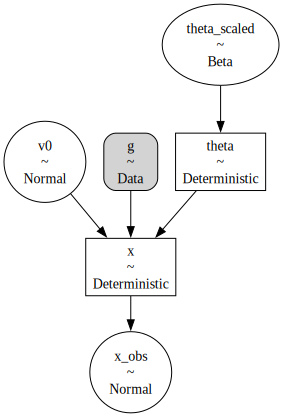

In [39]:
pm.model_to_graphviz(model)

In [40]:
# Draws from prior distribution
pm.draw([model['theta'], model['x'], model['x_obs']], 10)

[array([0.03102406, 1.05691317, 0.6537486 , 0.59003045, 0.37548481,
        1.01877744, 0.42172065, 0.29701614, 0.26047643, 1.18442881]),
 array([ 0.4989791 ,  6.3098751 , 10.75385239,  8.6363105 ,  8.02349583,
        10.27680007,  6.33413561,  6.224523  ,  6.44851259,  9.80029995]),
 array([ 0.75000358,  6.2653781 , 10.82641556,  8.65983455,  8.21344363,
        10.24010021,  6.50694346,  6.43338557,  6.73235198,  9.73920374])]

In [41]:
# Simulation model with known fixed vales of v0 and theta
sim_model = pm.do(model, {'v0': 10, 'theta_scaled': 0.5})

In [42]:
# Draws from the fixed parameter model
pm.draw([sim_model['x'], sim_model['x_obs']], 10)

[array([10.20408163, 10.20408163, 10.20408163, 10.20408163, 10.20408163,
        10.20408163, 10.20408163, 10.20408163, 10.20408163, 10.20408163]),
 array([10.2643395 , 10.02425985, 10.00938139, 10.37640767, 10.24919236,
        10.33391088, 10.12084377, 10.18289758, 10.00306631, 10.22906741])]

In [43]:
# Compare with expected result
10**2/9.8*np.sin(2*np.pi*0.25)

10.204081632653061

In [64]:
# Model for inference from observed distance
data_model = pm.observe(model, {'x_obs': 10.2})

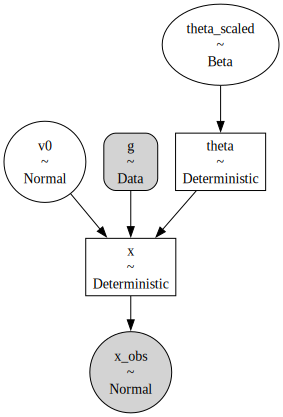

In [65]:
pm.model_to_graphviz(data_model)

In [66]:
with data_model:
    idata = pm.sample(1000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, progressbar=False, target_accept=0.95)

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [67]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.783,0.201,0.437,1.134,0.005,0.002,1567.0,2096.0,1.01
theta_scaled,0.499,0.128,0.278,0.722,0.003,0.002,1567.0,2096.0,1.01
v0,10.445,0.507,9.807,11.472,0.012,0.012,2365.0,2386.0,1.01
x,10.192,0.202,9.818,10.573,0.002,0.002,13069.0,10152.0,1.00


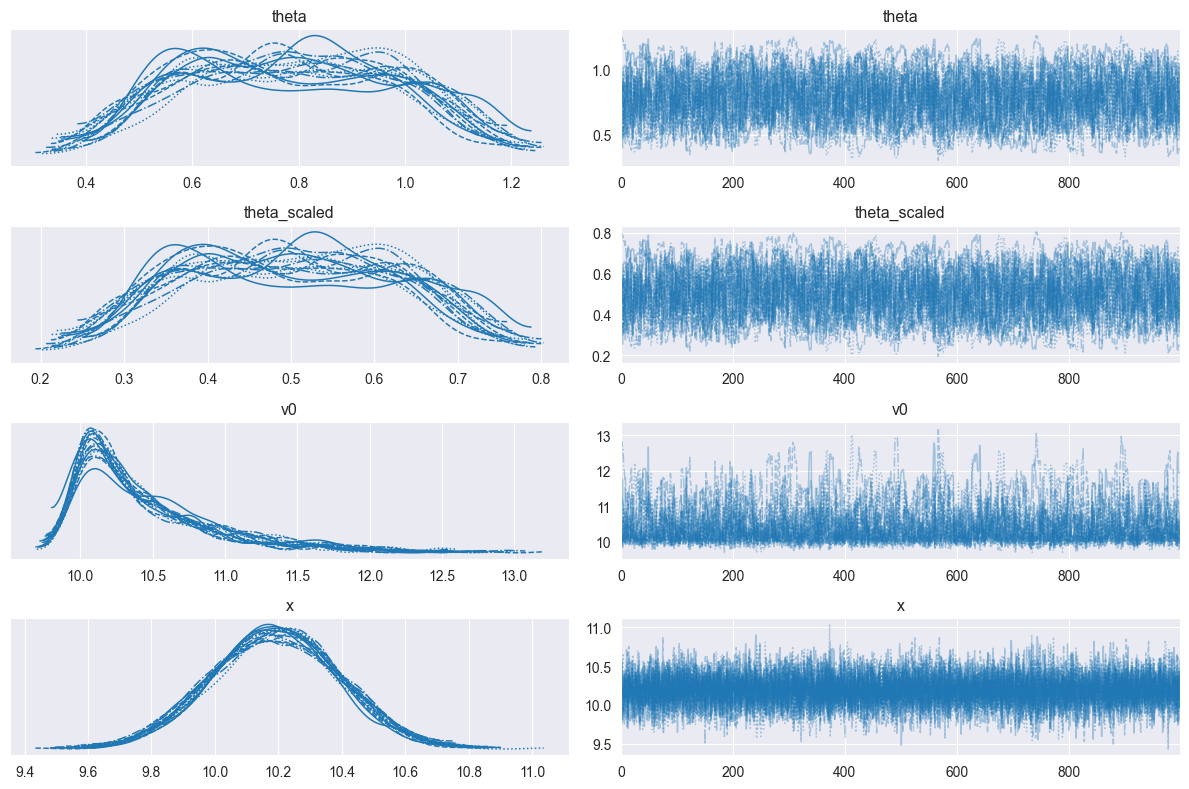

In [68]:
az.plot_trace(idata)
plt.tight_layout()

<Axes: title={'center': 'theta_scaled'}>

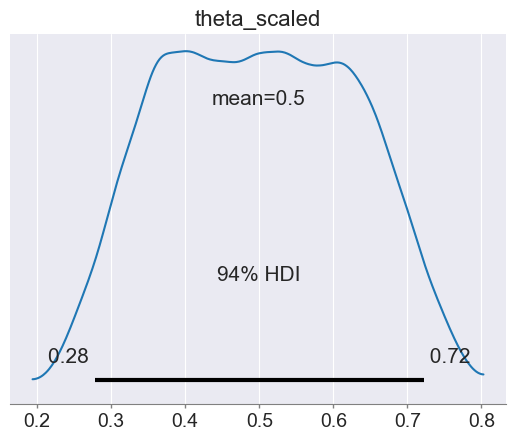

In [69]:
az.plot_posterior(idata, ['theta_scaled'])